# PPO-clip algorithm

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step as ps
from tf_agents.typing import types
from tf_agents.metrics import py_metrics
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import py_driver
from tf_agents.drivers import tf_driver
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import value_network
from tf_agents.agents import PPOClipAgent
from tf_agents.utils import common as cmn

import matplotlib.pyplot as plt
import qutip
from qutip import sigmap, expect

import random

import sys
sys.path.append('../')
from common.common import get_average_return, extract_double_action_policy

%matplotlib inline

* System parameters

In [ ]:
T = 3.5 # terminal time step
max_steps = 20 # number of time steps
random.seed(1991)

* Create training and evaluation environments and define actions

In [ ]:
# validate environment
from environments.qubit_env import QubitContinuousEnv

# define actions
# TODO: actions can be continuous within a range of course 
# actions will be the change in the magnetic field
max_Ω = 1.0
max_Δ = 0.5

environment = QubitContinuousEnv(T, max_steps, max_Ω, max_Δ, fidelity_threshold = 0.99, verbose_fg = False)
eval_environment = QubitContinuousEnv(T, max_steps, max_Ω, max_Δ, fidelity_threshold = 0.99, verbose_fg = False)

train_env = tf_py_environment.TFPyEnvironment(environment)
eval_env = tf_py_environment.TFPyEnvironment(eval_environment)

In [ ]:
fc_layer_params = (100, 75)
learning_rate = 1e-3
replay_buffer_capacity = 10000
num_iterations = 500
nb_episodes = 1
eval_interval = 10
checkpoint_dir = "../checkpoints/ppo_clip_qubit_omega_detuning/"

In [ ]:
actor_network = actor_distribution_network.ActorDistributionNetwork(
    input_tensor_spec = train_env.observation_spec(),
    output_tensor_spec = train_env.action_spec(),
    fc_layer_params = fc_layer_params,
    name = "Policy",
)

# use tha Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

train_step_counter = tf.Variable(0)

value_net = value_network.ValueNetwork(
    input_tensor_spec = train_env.observation_spec(),
    fc_layer_params = (100, 50, ),
    name = 'ValueNet'
) 

agent = PPOClipAgent(
    time_step_spec = train_env.time_step_spec(),
    action_spec = train_env.action_spec(),
    actor_net = actor_network,
    value_net = value_net,
    optimizer = optimizer,
    train_step_counter = train_step_counter,
    value_clipping = 0.2
)

agent.initialize()

In [ ]:
# collect trajectories
import reverb
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size = replay_buffer_capacity,
    sampler = reverb.selectors.Uniform(),
    remover = reverb.selectors.Fifo(),
    rate_limiter = reverb.rate_limiters.MinSize(1),
    signature = replay_buffer_signature
)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name = table_name,
    sequence_length = None,
    local_server = reverb_server
)

rb_observer = reverb_utils.ReverbAddEpisodeObserver(
    replay_buffer.py_client,
    table_name,
    replay_buffer_capacity
)

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = cmn.function(agent.train)

# Reset the train step.
# agent.train_step_counter.assign(0)

# create a driver which will run the simulations and collect tha dataset for our training
collect_driver = py_driver.PyDriver(
    environment,
    py_tf_eager_policy.PyTFEagerPolicy(agent.collect_policy, use_tf_function = True),
    observers = [rb_observer],
    max_episodes = nb_episodes
)

# create checkpointer to load training and continue
""" checkpointer = cmn.Checkpointer(
    ckpt_dir = checkpoint_dir,
    max_to_keep = 1,
    agent = agent,
    policy = agent.policy,
    replay_buffer = replay_buffer,
)

checkpointer.initialize_or_restore() """

In [7]:
avg_returns = [get_average_return(eval_env, agent.policy, 10)]

for _ in range(num_iterations):
    initial_time_step = environment.reset()
    collect_driver.run(initial_time_step)

    # create dataset from trajectories
    dataset = replay_buffer.as_dataset(sample_batch_size = 1)
    iterator = iter(dataset)

    trajectories , _ = next(iterator)

    # train 
    train_loss = agent.train(experience = trajectories)

    replay_buffer.clear()

    step = agent.train_step_counter.numpy()

    if step % 50 == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))

    if step % eval_interval == 0:
        avg_return = get_average_return(eval_env, agent.policy, 10)
        avg_returns.append(avg_return)


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (108787) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (108787) so Table uniform_table is accessed directly without gRPC.


step = 50: loss = 303.8389892578125


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (108787) so Table uniform_table is accessed directly without gRPC.


step = 100: loss = 16.51698875427246
step = 150: loss = 21.290355682373047


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (108787) so Table uniform_table is accessed directly without gRPC.


step = 200: loss = 11.50787353515625
step = 250: loss = 5.16702938079834
step = 300: loss = 12.388681411743164
step = 350: loss = 0.7913215756416321


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (108787) so Table uniform_table is accessed directly without gRPC.


step = 400: loss = 21.434045791625977
step = 450: loss = 3.407557249069214
step = 500: loss = 5.7494916915893555
step = 550: loss = 11.14309024810791
step = 600: loss = 6.4847412109375
step = 650: loss = -0.3009531497955322
step = 700: loss = 1.0090283155441284
step = 750: loss = -0.19890862703323364


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (108787) so Table uniform_table is accessed directly without gRPC.


step = 800: loss = 15.168278694152832
step = 850: loss = 1.6144450902938843
step = 900: loss = 1.52554190158844
step = 950: loss = 1.2695088386535645
step = 1000: loss = 0.5645828247070312
step = 1050: loss = 0.34996187686920166
step = 1100: loss = 0.18765008449554443
step = 1150: loss = 5.4492292404174805
step = 1200: loss = -0.19880303740501404
step = 1250: loss = -0.10397598147392273
step = 1300: loss = -0.20265738666057587
step = 1350: loss = -0.40969550609588623
step = 1400: loss = -4.061788558959961
step = 1450: loss = 1.0425899028778076
step = 1500: loss = 1.0350863933563232
step = 1550: loss = -0.267794132232666


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (108787) so Table uniform_table is accessed directly without gRPC.


step = 1600: loss = -0.037905216217041016
step = 1650: loss = -6.225770950317383
step = 1700: loss = -0.6223804950714111
step = 1750: loss = -0.11365954577922821
step = 1800: loss = 0.02891971915960312
step = 1850: loss = -0.24656876921653748
step = 1900: loss = -0.33486026525497437
step = 1950: loss = 0.09857248514890671
step = 2000: loss = -0.18037131428718567
step = 2050: loss = -0.17437519133090973
step = 2100: loss = -0.459601491689682
step = 2150: loss = -0.7392187118530273
step = 2200: loss = -1.9464521408081055
step = 2250: loss = -12.418190956115723
step = 2300: loss = 0.4498758614063263
step = 2350: loss = -0.24158214032649994
step = 2400: loss = -0.16269011795520782
step = 2450: loss = -0.32692813873291016
step = 2500: loss = 0.14629724621772766
step = 2550: loss = -1.9013289213180542
step = 2600: loss = -0.10865330696105957
step = 2650: loss = -0.09826748073101044
step = 2700: loss = -0.33894848823547363
step = 2750: loss = -0.1320713311433792
step = 2800: loss = -0.1801473

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (108787) so Table uniform_table is accessed directly without gRPC.


step = 3200: loss = 0.0027695968747138977
step = 3250: loss = 0.004060571547597647
step = 3300: loss = 0.0024178149178624153
step = 3350: loss = -0.0016553960740566254
step = 3400: loss = 0.0007798903388902545
step = 3450: loss = 0.0004548121942207217
step = 3500: loss = -0.01014361809939146
step = 3550: loss = -0.002286134287714958
step = 3600: loss = 0.0012196454918012023
step = 3650: loss = -0.00162185647059232
step = 3700: loss = -0.004247378557920456
step = 3750: loss = -0.022999605163931847
step = 3800: loss = -0.02540568634867668
step = 3850: loss = -0.11921154707670212
step = 3900: loss = -0.13399377465248108
step = 3950: loss = -0.11207135766744614
step = 4000: loss = -0.22365258634090424
step = 4050: loss = -0.4086301326751709
step = 4100: loss = -0.16635297238826752
step = 4150: loss = -0.12230581790208817
step = 4200: loss = 0.26989325881004333
step = 4250: loss = -0.18359071016311646
step = 4300: loss = -0.23272903263568878
step = 4350: loss = -0.1144934743642807
step = 44

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (108787) so Table uniform_table is accessed directly without gRPC.


step = 6400: loss = 7.687000751495361
step = 6450: loss = 5.992973327636719
step = 6500: loss = 5.2359113693237305
step = 6550: loss = 3.4411420822143555
step = 6600: loss = 8.30052661895752
step = 6650: loss = 17.617534637451172
step = 6700: loss = -2.2620182037353516
step = 6750: loss = 29.10531997680664
step = 6800: loss = 17.138626098632812
step = 6850: loss = 28.160226821899414
step = 6900: loss = 40.383758544921875
step = 6950: loss = 103.00891876220703
step = 7000: loss = 63.35842514038086
step = 7050: loss = 45.632789611816406
step = 7100: loss = 33.26304244995117
step = 7150: loss = 52.78904342651367
step = 7200: loss = 3.6850693225860596
step = 7250: loss = 18.36815643310547
step = 7300: loss = 4.164135456085205
step = 7350: loss = 7.201383113861084
step = 7400: loss = 9.156072616577148
step = 7450: loss = 4.307619094848633
step = 7500: loss = 5.235091209411621
step = 7550: loss = 3.0454366207122803
step = 7600: loss = 4.26499080657959
step = 7650: loss = 4.673895835876465
st

In [8]:
# checkpointer.save(train_step_counter)

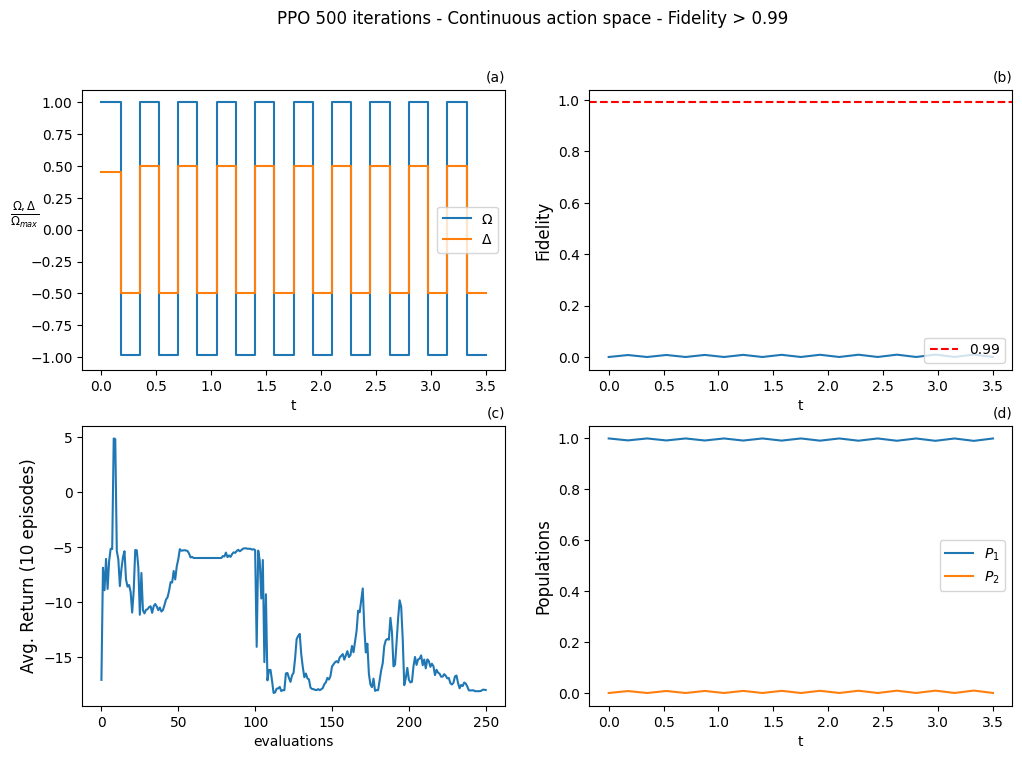

In [9]:
greedy_actions, [optimal_omegas, optimal_detuning], states, fidelities = extract_double_action_policy(environment, agent)

population2 = expect(sigmap().dag() * sigmap(), states)
population1 = 1 - population2

time_span = np.arange(len(optimal_omegas))
time_span = [t * T / max_steps for t in time_span]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(12)
fig.suptitle(f'PPO {num_iterations} iterations - Continuous action space - Fidelity > 0.99')

ax1.step(time_span, optimal_omegas, where = 'post', label = 'Ω')
ax1.step(time_span, optimal_detuning, where = 'post', label = 'Δ')
ax1.set_ylabel(r"$\frac{\Omega, \Delta}{\Omega_{max}}$", rotation = 0, fontsize = 12)
ax1.set_ylim((-1.1, 1.1))
ax1.set_xlabel(f"t")
ax1.set_title("(a)", loc = "right", fontsize = 10)
ax1.legend()

ax2.plot(time_span, fidelities)
ax2.axhline(y = 0.99, color = 'r', linestyle = '--', label = '0.99')
ax2.set_ylabel("Fidelity", rotation = 90, fontsize = 12)
ax2.set_xlabel(f"t")
ax2.legend(loc = 'lower right')
ax2.set_title("(b)", loc = "right", fontsize = 10)

ax4.plot(time_span, population1, label = r"$P_1$")
ax4.plot(time_span, population2, label = r"$P_2$")
ax4.set_ylabel("Populations", rotation = 90, fontsize = 12)
ax4.set_xlabel(f"t")
ax4.set_title("(d)", loc = "right", fontsize = 10)
ax4.legend()

time_span3 = range(len(avg_returns))
ax3.plot(time_span3, avg_returns)
ax3.set_ylabel("Avg. Return (10 episodes)", rotation = 90, fontsize = 12)
ax3.set_xlabel(f"evaluations")
ax3.set_title("(c)", loc = "right", fontsize = 10)
plt.show()